# Testing the effect of two scenarios, for various method candidates
- Opinion vectors are orthogonal, and another orthogonal opinion vector is added (e.g. 2→3)
- Opinion vectors are duplicated (e.g. 2→4)

In [1]:
# import sys
# sys.path.append('..')

import tests.methods.torch_nvd as nvd
import tests.methods.utils as utils

import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import numpy as np
import pandas as pd
import networkx as nx

# import random

import scipy.stats as st
# import torch
# import torch_geometric

In [2]:
def SBM_graph(n_comms, p_out, intercon, nodes_per_comm):
    """
    Generate a graph with SBM with given parameters. 
    n_comms: int, number of communities
    p_out: float, probability that each node will connect to a node in a different community
    intercon: int, number of other communities each community is connected to
    """
    p = utils.ideo_make_p(n_comms=n_comms, p_out=p_out, intercon=intercon)
    G = utils.ideo_make_G(p=p, n_comms=n_comms, nodes_per_comm=nodes_per_comm)
    return G

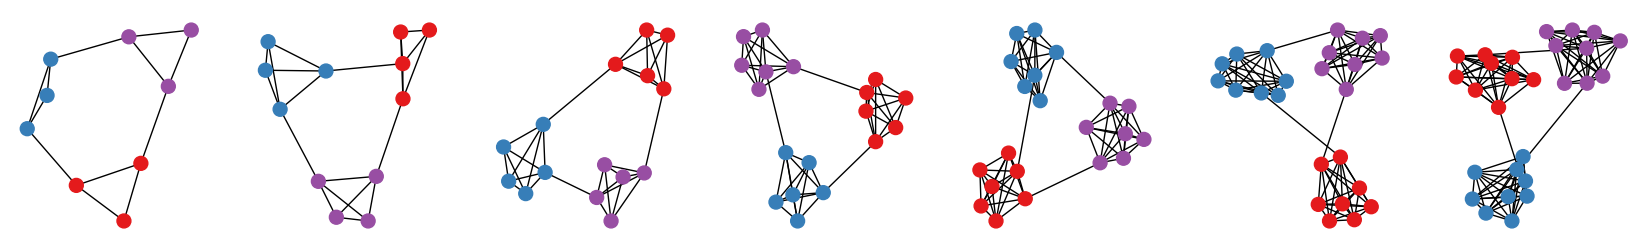

In [3]:
nodes_per_comms_s = range(3, 10)
labels = False

fig, ax = plt.subplots(1, len(nodes_per_comms_s), figsize=(3*len(nodes_per_comms_s), 3))

for i, nodes in enumerate(nodes_per_comms_s):

    G = utils.make_community_graph(n_comms=3, nodes_per_comm=nodes)
    
    pos = nx.spring_layout(G, k=0.9)

    # colour nodes by community, with desaturation
    comms = [0]*nodes + [1]*nodes + [2]*nodes
    colours = plt.cm.Set1(np.array(comms)/5)

    nx.draw(G, ax=ax[i], node_size=100, with_labels=labels, pos=pos, node_color=colours)

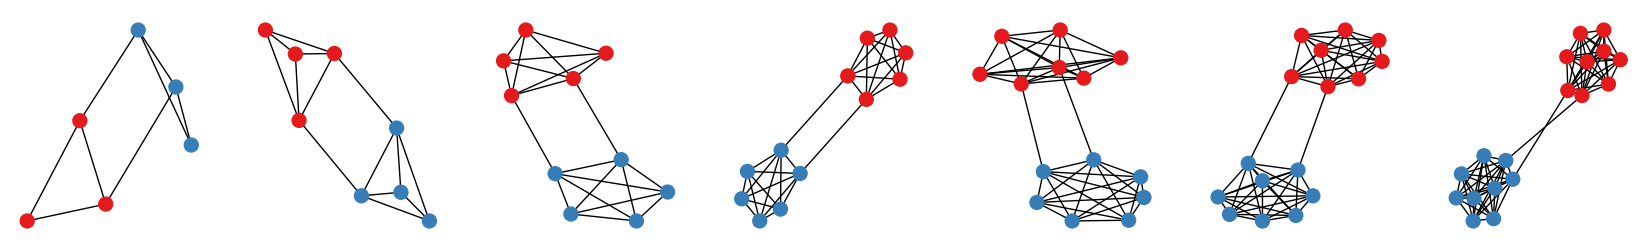

In [12]:
nodes_per_comms_s = range(3, 10)
labels = False

fig, ax = plt.subplots(1, len(nodes_per_comms_s), figsize=(3*len(nodes_per_comms_s), 3))

for i, nodes in enumerate(nodes_per_comms_s):

    G = utils.make_community_graph(n_comms=2, nodes_per_comm=nodes)
    
    pos = nx.spring_layout(G, k=0.9)

    # colour nodes by community, with desaturation
    comms = [0]*nodes + [1]*nodes
    colours = plt.cm.Set1(np.array(comms)/5)

    nx.draw(G, ax=ax[i], node_size=100, with_labels=labels, pos=pos, node_color=colours)

In [23]:
metrics = [('Avg pairwise dist', nvd.pairwise_average), 
           ('Avg dist to mean', nvd.avg_dist_to_mean), 
           ('PCA', nvd.PCA_manifold), 
           ('Euclidean MDS', nvd.MDS_euclidean_manifold)]  # ('Total variation', nvd.total_variation)

metric_names = [m[0] for m in metrics]
polarization_metrics = [m[1] for m in metrics]

random_run_metrics = {'PCA', 'Euclidean MDS'}

## Adding orthogonally opinionated nodes

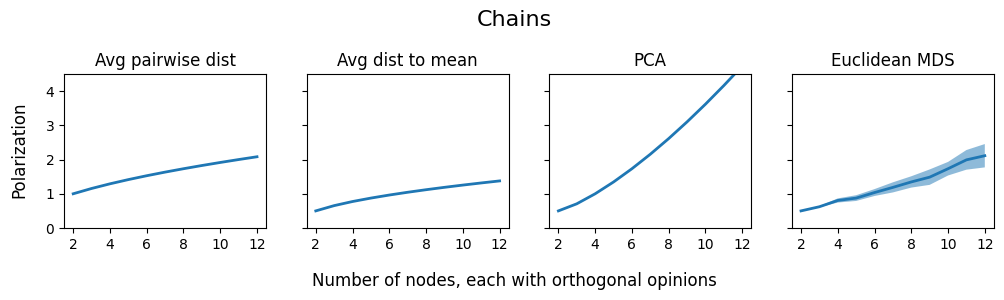

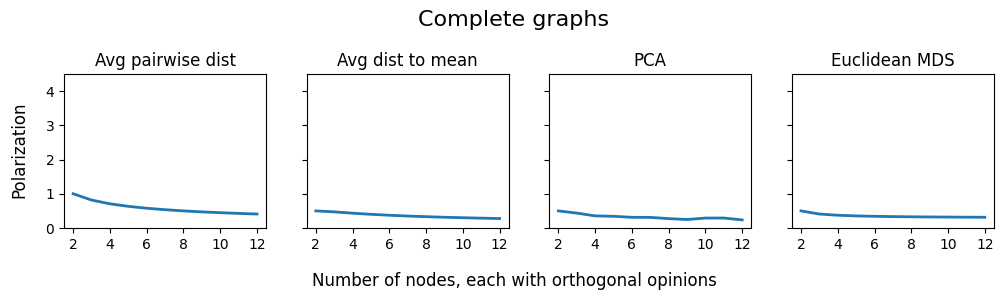

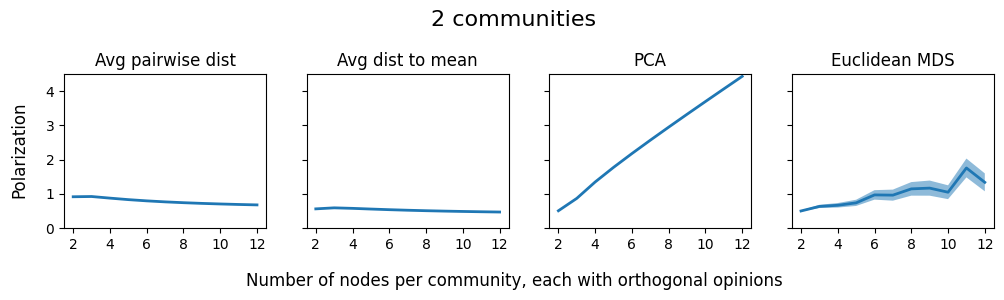

In [47]:
num_opinions_range = range(2, 13)
num_runs = 50

for graph_name, graph_type in [('Chains', nx.path_graph), 
                               ('Complete graphs', nx.complete_graph),
                               ('2 communities', utils.make_community_graph)]:

    fig, ax = plt.subplots(1, len(polarization_metrics), figsize=(3*len(polarization_metrics), 2), sharey=True)

    for i, (metric_name, polarization_metric) in enumerate(zip(metric_names, polarization_metrics)):
        means = np.zeros(len(num_opinions_range))
        lower_confs = np.zeros(len(num_opinions_range))
        higher_confs = np.zeros(len(num_opinions_range))

        for opinion_index, num_opinions in enumerate(num_opinions_range):

            if metric_name not in random_run_metrics:
                curr_num_runs = 1
            else:
                curr_num_runs = num_runs
        
            run_pols = np.zeros(curr_num_runs)
            
            for run in range(curr_num_runs):
                
                if graph_type == utils.make_community_graph:
                    G = graph_type(n_comms=2, nodes_per_comm=num_opinions)
                    o = pd.DataFrame(columns=['o'+str(i) for i in range(num_opinions*2)], data=np.identity(num_opinions*2))
                else:
                    G = graph_type(num_opinions)
                    o = pd.DataFrame(columns=['o'+str(i) for i in range(num_opinions)], data=np.identity(num_opinions))

                
                tensor = nvd.make_tensor(G, o)
                polarization = polarization_metric(tensor)
                run_pols[run] = polarization

            means[opinion_index] = np.mean(run_pols)

            if metric_name in random_run_metrics:

                # Add small random noise to avoid RuntimeWarning: invalid value encountered in multiply
                run_pols += np.random.normal(0, 1e-10, len(run_pols))

                # Calculate the 95% confidence intervals
                lower_conf, higher_conf = st.t.interval(0.95, len(run_pols)-1, loc=np.mean(run_pols), scale=st.sem(run_pols))

                lower_confs[opinion_index] = lower_conf
                higher_confs[opinion_index] = higher_conf

        ax[i].plot(num_opinions_range, means, lw=2)

        if metric_name in random_run_metrics:
            ax[i].fill_between(num_opinions_range, higher_confs, lower_confs, alpha=.5, linewidth=0)

        # ax[i].hlines(0, num_opinions_range[0]-1, xmax=num_opinions_range[-1]+1, colors='gray', linestyles='dashed')
        ax[i].set_title(metric_name)
        ax[i].set_xticks([num for num in num_opinions_range if num % 2 == 0])
        ax[i].set_ylim(0, 4.5)

    if graph_type == utils.make_community_graph:
        fig.supxlabel('Number of nodes per community, each with orthogonal opinions', y=-0.2)
    else:
        fig.supxlabel('Number of nodes, each with orthogonal opinions', y=-0.2)
    fig.supylabel('Polarization', x=0.08)
    fig.suptitle(graph_name, y=1.2, fontsize=16)

## Converting neutral community to third orthogonal opinion

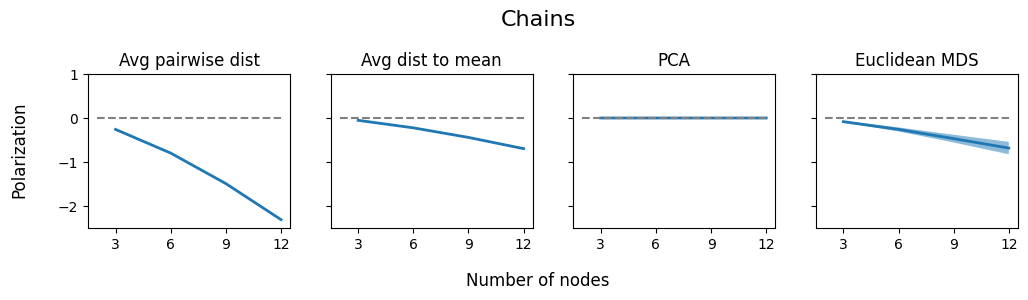

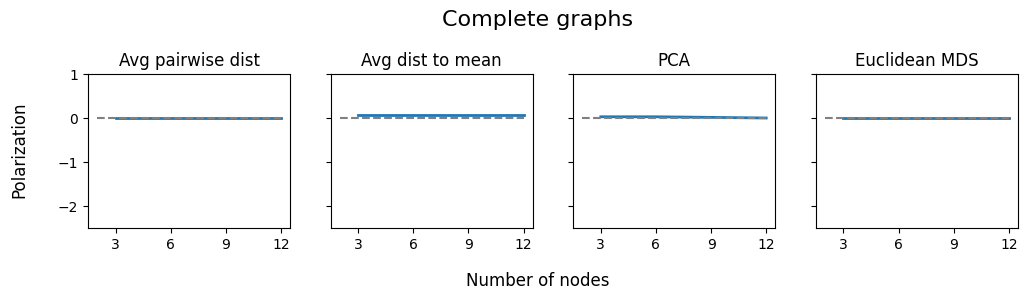

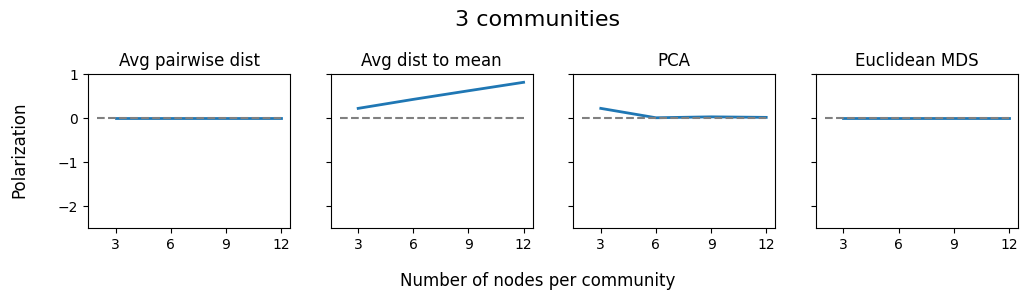

In [46]:
num_nodes_range = range(3, 13, 3)
num_communities = 3
num_runs = 50

for graph_name, graph_type in [('Chains', nx.path_graph), 
                               ('Complete graphs', nx.complete_graph),
                               ('3 communities', utils.make_community_graph)]:

    fig, ax = plt.subplots(1, len(polarization_metrics), figsize=(3*len(polarization_metrics), 2), sharey=True)

    for i, (metric_name, polarization_metric) in enumerate(zip(metric_names, polarization_metrics)):
        means = np.zeros(len(num_nodes_range))
        lower_confs = np.zeros(len(num_nodes_range))
        higher_confs = np.zeros(len(num_nodes_range))

        for opinion_index, num_nodes in enumerate(num_nodes_range):
            if graph_type == utils.make_community_graph:
                nodes_per_comm = num_nodes
            else:
                nodes_per_comm = num_nodes//num_communities
    
            neutral_polarization = 0
            third_polarization = 0

            if metric_name not in random_run_metrics:
                curr_num_runs = 1
            else:
                curr_num_runs = num_runs
        
            run_pols = np.zeros(curr_num_runs)
            
            for run in range(curr_num_runs):
                
                if graph_type == utils.make_community_graph:
                    G = graph_type(n_comms=num_communities, nodes_per_comm=nodes_per_comm)
                else:
                    G = graph_type(num_nodes)

                # neutral opinion polarization
                o = pd.DataFrame(columns=['o0', 'o1'], data=np.vstack((np.array([(1,0)]*nodes_per_comm),
                                                                    np.array([(0,0)]*nodes_per_comm),
                                                                    np.array([(0,1)]*nodes_per_comm))))
                tensor = nvd.make_tensor(G, o)
                neutral_polarization = polarization_metric(tensor)

                # third opinion polarization
                o = pd.DataFrame(columns=['o0', 'o1', 'o2'], data=np.vstack((np.array([(1,0,0)]*nodes_per_comm),
                                                                            np.array([(0,1,0)]*nodes_per_comm),
                                                                            np.array([(0,0,1)]*nodes_per_comm))))
                tensor = nvd.make_tensor(G, o)
                third_polarization = polarization_metric(tensor)

                difference = third_polarization - neutral_polarization

                run_pols[run] = difference

            means[opinion_index] = np.mean(run_pols)

            if metric_name in random_run_metrics:

                # Add small random noise to avoid RuntimeWarning: invalid value encountered in multiply
                run_pols += np.random.normal(0, 1e-10, len(run_pols))

                # Calculate the 95% confidence intervals
                lower_conf, higher_conf = st.t.interval(0.95, len(run_pols)-1, loc=np.mean(run_pols), scale=st.sem(run_pols))

                lower_confs[opinion_index] = lower_conf
                higher_confs[opinion_index] = higher_conf

        ax[i].plot(num_nodes_range, means, lw=2)

        if metric_name in random_run_metrics:
            ax[i].fill_between(num_nodes_range, higher_confs, lower_confs, alpha=.5, linewidth=0)

        ax[i].hlines(0, num_nodes_range[0]-1, xmax=num_nodes_range[-1], colors='gray', linestyles='dashed')
        ax[i].set_title(metric_name)
        # set xticks to num_nodes_range
        ax[i].set_xticks(num_nodes_range)
        ax[i].set_ylim(-2.5, 1)

    if graph_type == utils.make_community_graph:
        fig.supxlabel('Number of nodes per community', y=-0.2)
    else:
        fig.supxlabel('Number of nodes', y=-0.2)
    fig.supylabel('Polarization', x=0.06)
    fig.suptitle(graph_name, y=1.2, fontsize=16)

## Duplicating one or more opinion vectors

Note: for some reason it makes no difference whether I duplicate one or 3 opinions, is it a bug?

### Duplicating all 3 orthogonal opinions

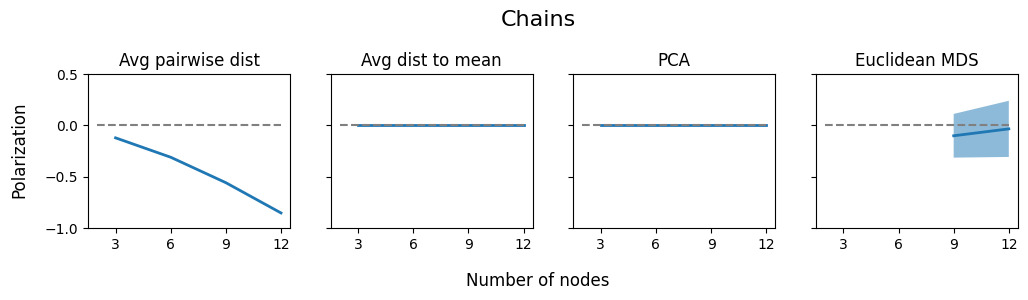

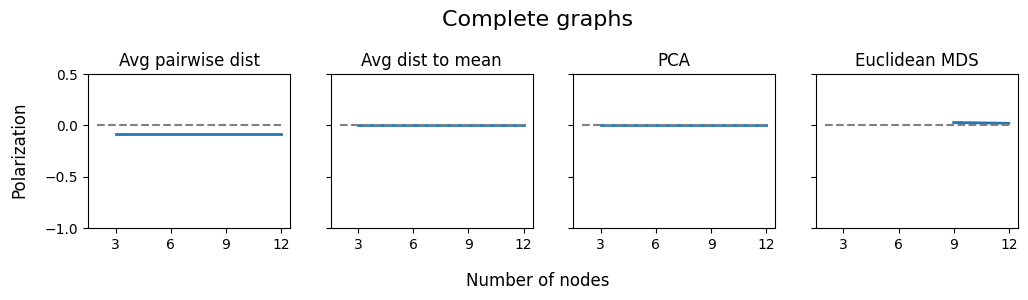

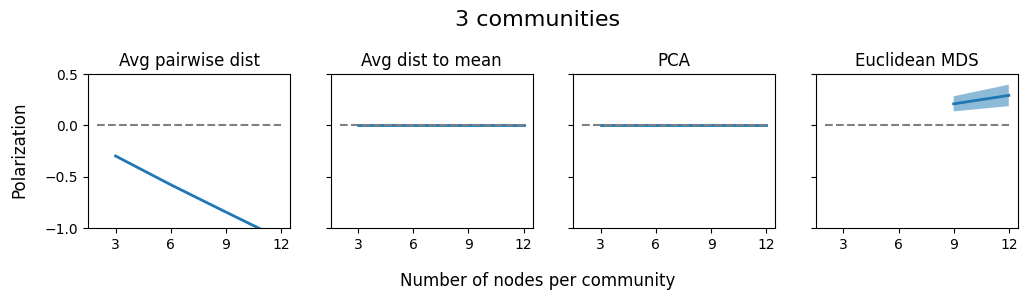

In [48]:
num_nodes_range = range(3, 13, 3)
num_communities = 3
num_runs = 50

for graph_name, graph_type in [('Chains', nx.path_graph), 
                               ('Complete graphs', nx.complete_graph),
                               ('3 communities', utils.make_community_graph)]:

    fig, ax = plt.subplots(1, len(polarization_metrics), figsize=(3*len(polarization_metrics), 2), sharey=True)

    for i, (metric_name, polarization_metric) in enumerate(zip(metric_names, polarization_metrics)):
        means = np.zeros(len(num_nodes_range))
        lower_confs = np.zeros(len(num_nodes_range))
        higher_confs = np.zeros(len(num_nodes_range))

        for opinion_index, num_nodes in enumerate(num_nodes_range):
            if graph_type == utils.make_community_graph:
                nodes_per_comm = num_nodes
            else:
                nodes_per_comm = num_nodes//num_communities
    
            neutral_polarization = 0
            third_polarization = 0

            if metric_name not in random_run_metrics:
                curr_num_runs = 1
            else:
                curr_num_runs = num_runs
        
            run_pols = np.zeros(curr_num_runs)
            
            for run in range(curr_num_runs):
                
                if graph_type == utils.make_community_graph:
                    G = graph_type(n_comms=num_communities, nodes_per_comm=nodes_per_comm)
                else:
                    G = graph_type(num_nodes)

                o = pd.DataFrame(columns=['o0', 'o1', 'o2'], data=np.vstack((np.array([(1,0,0)]*nodes_per_comm),
                                                                        np.array([(0,1,0)]*nodes_per_comm),
                                                                        np.array([(0,0,1)]*nodes_per_comm))))

                tensor = nvd.make_tensor(G, o)
                unique_polarization = polarization_metric(tensor)

                # duplicate o
                dup_o = pd.concat([o, o], axis=1)

                dup_tensor = nvd.make_tensor(G, dup_o)
                duplicate_polarization = polarization_metric(dup_tensor)

                difference = duplicate_polarization - unique_polarization

                run_pols[run] = difference

            means[opinion_index] = np.mean(run_pols)

            if metric_name in random_run_metrics:

                # Add small random noise to avoid RuntimeWarning: invalid value encountered in multiply
                run_pols += np.random.normal(0, 1e-10, len(run_pols))

                # Calculate the 95% confidence intervals
                lower_conf, higher_conf = st.t.interval(0.95, len(run_pols)-1, loc=np.mean(run_pols), scale=st.sem(run_pols))

                lower_confs[opinion_index] = lower_conf
                higher_confs[opinion_index] = higher_conf

        ax[i].plot(num_nodes_range, means, lw=2)

        if metric_name in random_run_metrics:
            ax[i].fill_between(num_nodes_range, higher_confs, lower_confs, alpha=.5, linewidth=0)

        ax[i].hlines(0, num_nodes_range[0]-1, xmax=num_nodes_range[-1], colors='gray', linestyles='dashed')
        ax[i].set_title(metric_name)
        # set xticks to num_nodes_range
        ax[i].set_xticks(num_nodes_range)
        ax[i].set_ylim(-1, 0.5)

    if graph_type == utils.make_community_graph:
        fig.supxlabel('Number of nodes per community', y=-0.2)
    else:
        fig.supxlabel('Number of nodes', y=-0.2)
    fig.supylabel('Polarization', x=0.06)
    fig.suptitle(graph_name, y=1.2, fontsize=16)

### Duplicating 1 of 3 orthogonal opinions

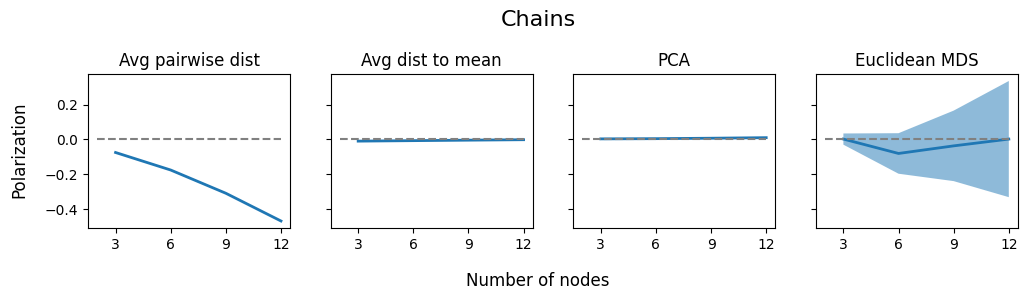

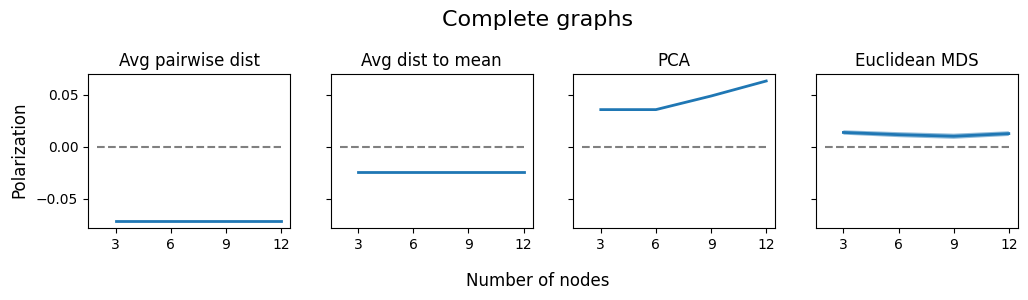

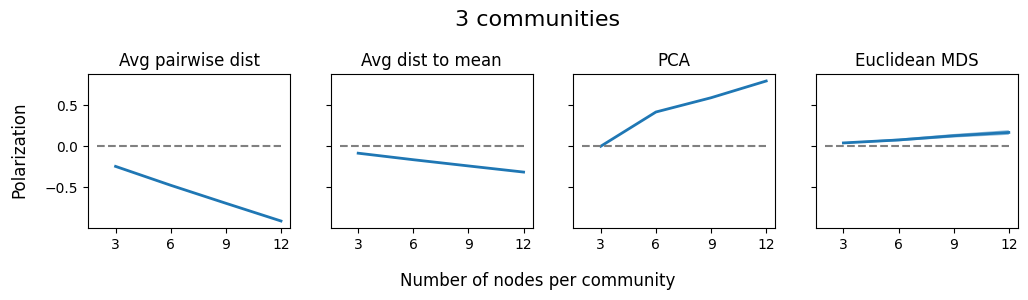

In [39]:
num_nodes_range = range(3, 13, 3)
num_communities = 3
num_runs = 50

for graph_name, graph_type in [('Chains', nx.path_graph), 
                               ('Complete graphs', nx.complete_graph),
                               ('3 communities', utils.make_community_graph)]:

    fig, ax = plt.subplots(1, len(polarization_metrics), figsize=(3*len(polarization_metrics), 2), sharey=True)

    for i, (metric_name, polarization_metric) in enumerate(zip(metric_names, polarization_metrics)):
        means = np.zeros(len(num_nodes_range))
        lower_confs = np.zeros(len(num_nodes_range))
        higher_confs = np.zeros(len(num_nodes_range))

        for opinion_index, num_nodes in enumerate(num_nodes_range):
            if graph_name == '3 communities':
                nodes_per_comm = num_nodes
            else:
                nodes_per_comm = num_nodes//num_communities
    
            neutral_polarization = 0
            third_polarization = 0

            if metric_name not in random_run_metrics:
                curr_num_runs = 1
            else:
                curr_num_runs = num_runs
        
            run_pols = np.zeros(curr_num_runs)
            
            for run in range(curr_num_runs):
                
                if graph_type == utils.make_community_graph:
                    G = graph_type(n_comms=num_communities, nodes_per_comm=nodes_per_comm)
                else:
                    G = graph_type(num_nodes)

                o = pd.DataFrame(columns=['o0', 'o1', 'o2'], data=np.vstack((np.array([(1,0,0)]*nodes_per_comm),
                                                                        np.array([(0,1,0)]*nodes_per_comm),
                                                                        np.array([(0,0,1)]*nodes_per_comm))))

                tensor = nvd.make_tensor(G, o)
                unique_polarization = polarization_metric(tensor)

                # duplicate last column of o
                dup_o = pd.concat([o, o.iloc[:, -1]], axis=1)

                dup_tensor = nvd.make_tensor(G, dup_o)
                duplicate_polarization = polarization_metric(dup_tensor)

                difference = duplicate_polarization - unique_polarization

                run_pols[run] = difference

            means[opinion_index] = np.mean(run_pols)

            if metric_name in random_run_metrics:

                # Add small random noise to avoid RuntimeWarning: invalid value encountered in multiply
                run_pols += np.random.normal(0, 1e-10, len(run_pols))

                # Calculate the 95% confidence intervals
                lower_conf, higher_conf = st.t.interval(0.95, len(run_pols)-1, loc=np.mean(run_pols), scale=st.sem(run_pols))

                lower_confs[opinion_index] = lower_conf
                higher_confs[opinion_index] = higher_conf

        ax[i].plot(num_nodes_range, means, lw=2)

        if metric_name in random_run_metrics:
            ax[i].fill_between(num_nodes_range, higher_confs, lower_confs, alpha=.5, linewidth=0)

        ax[i].hlines(0, num_nodes_range[0]-1, xmax=num_nodes_range[-1], colors='gray', linestyles='dashed')
        ax[i].set_title(metric_name)
        # set xticks to num_nodes_range
        ax[i].set_xticks(num_nodes_range)

    if graph_name == '3 communities':
        fig.supxlabel('Number of nodes per community', y=-0.2)
    else:
        fig.supxlabel('Number of nodes', y=-0.2)
    fig.supylabel('Polarization', x=0.06)
    fig.suptitle(graph_name, y=1.2, fontsize=16)

In [22]:
def plot_test(num_opinions_range, n_nodes, n_comms, p_out, intercon, polarization_metrics, metric_names, plot_title, plot_xlabel, plot_ylabel, opinion_type, num_runs=10):
    """
    Plot the polarization of a SBM graph with different number of opinions and different polarization metrics.
    
    num_opinions_range: range, range of number of opinions to test
    num_runs: int, number of runs random initializations for each test
    opinion_types: list, list of opinion types to test
    """

    if not n_nodes % n_comms == 0:
        raise ValueError(f'n_nodes={n_nodes} not divisible by n_comms={n_comms}')
    nodes_per_comm = n_nodes//n_comms

    fig, ax = plt.subplots(1, len(polarization_metrics), figsize=(4*len(polarization_metrics), 3), sharey=True)

    for i, (metric_name, polarization_metric) in enumerate(zip(metric_names, polarization_metrics)):
        pols = np.array([])
        pol_lower_conf = np.array([])
        pol_higher_conf = np.array([])

        for num_opinions in num_opinions_range:

            run_pols = np.zeros(num_runs)

            for run in range(num_runs):

                G = SBM_graph(n_nodes, n_comms, p_out, intercon, nodes_per_comm)
    

                if opinion_type == 'unique':
                    o = pd.DataFrame(columns=['o'+str(i) for i in range(num_opinions)], data=np.identity(num_opinions))
                elif opinion_type == 'orthogonal':
                    o = pd.DataFrame(columns=['o0', 'o1', 'o2'], data=np.vstack((np.array([(1,0,0)]*nodes_per_comm),
                                                                                np.array([(0,1,0)]*nodes_per_comm),
                                                                                np.array([(0,0,1)]*nodes_per_comm))))
                elif opinion_type == 'correlated':
                    o = pd.DataFrame(columns=['o0', 'o1', 'o2'], data=np.vstack((np.array([(1,1,0)]*nodes_per_comm),
                                                                                np.array([(0,1,1)]*nodes_per_comm),
                                                                                np.array([(1,0,1)]*nodes_per_comm))))
                else:
                    raise ValueError(f'opinion_type={opinion_type} not valid. Must be one of "unique", "orthogonal", "correlated".')

                tensor = nvd.make_tensor(G, o)
                Linv = nvd._Linv(tensor)

                polarization = polarization_metric(tensor, Linv=Linv)
                run_pols[run] = polarization

            # Calculate the mean polarization of num_runs runs
            pols = np.append(pols, np.mean(run_pols))  

            # Calculate the 95% confidence intervals of the mean polarization
            lower_conf, higher_conf = st.t.interval(0.95, len(run_pols)-1, loc=np.mean(run_pols), scale=st.sem(run_pols))
            pol_lower_conf = np.append(pol_lower_conf, lower_conf)
            pol_higher_conf = np.append(pol_higher_conf, higher_conf)

        ax[i].plot(num_opinions_range, pols, lw=2)
        ax[i].fill_between(num_opinions_range, pol_higher_conf, pol_lower_conf, alpha=.5, linewidth=0)  # Shade the 95% confidence interval around the mean
        ax[i].set_title(metric_name)

    fig.suptitle(plot_title, y=1.1, fontsize=16)
    fig.supxlabel(plot_xlabel, y=-0.1)
    fig.supylabel(plot_ylabel, x=0.05);